# Exercise Sheet No. 7

---

> Machine Learning for Natural Sciences, Summer 2025, T.T.-Prof. Pascal Friederich
>
> Deadline: Monday 16.06.2025, 8:00 am
>
> Tutor: jona.oestreicher@kit.edu
>
> **Please ask questions in the forum/discussion board and for the grading issue contact the Tutor **
------
**Topic**: This exercise sheet will use neural networks for a molecular dynamics simulation

Please add here your group members' names and student IDs. 

You are encouraged to work in groups of a maximum of 3 people, however **each of you** has to submit a solution.

Names: Christopher Roth, Isabella Mebus Kishi de Oliveira

IDs: utxus, utmce

# Molecular dynamics simulation

"Molecular dynamics (MD) is a computer simulation method for analyzing the physical movements of atoms and molecules [that are interacting to each other and creating forces among themselves]. (...)  In the most common version, the trajectories (movements) of atoms and molecules are determined by numerically solving Newton's equations of motion for a system of interacting particles, where forces between the particles and their potential energies are often calculated using interatomic potentials or molecular mechanics force fields." [wikipedia](https://en.wikipedia.org/wiki/Molecular_dynamics)

In this exercise we will perform a MD simulation of a single very simple molecule, namely methanol (CH3OH). The propagation of the atomic positions in time is usually treated classically and is given by Newton's Equation for an ensemble of particles:

$$ F(X) = - \nabla U(X) = M \dot{V}(t)$$

$$ V(t) = \dot{X}(t) $$

A molecular dynamics simulation therfore requires the definition of a potential function $U(X)$, or a description of the force terms $F(X)$ by which the particles in the simulation will interact. To correctly capture the molecular interactions, different methods are used for MD simulations (different methods of calculating the energy of atoms and then calculating the forces between them), depending on system. The most common are:

* (Classical) force fields are empirical energy functions and consist of a summation of bonded interactions (associated with chemical bonds, bond angles, and dihedral angles), and non-bonded interactions (associated with van der Waals interaction, Pauli repulsion and electrostatic interaction)

* Pair potentials between particles, in which the total potential energy can be calculated from the sum of energy contributions between pairs of atoms. An example of such a pair potential is the non-bonded Lennard–Jones potential.

* Semi-empirical potentials are based on quantum mechanical methods, but use empirical parameterizations to estimate the energy contributions of orbitals, e.g. tight-binding potentials.

*  Ab Initio Molecular Dynamics (AIMD) simulations use quantum mechanical methods to compute energies and forces, which is more accurate than classical force fields and can describe chemical processes (e.g. bond breaking or formation) but quantum mechanical methods are much more expensive and thus limited in system size and time scale.

* QM/MM methods are hybrid methods between quantum mechanical (QM) and molecular or classical mechanics (MM), where only a small (and important) part is modeled using QM methods.

The goal of this exercise is to derive the correct potential energy by a neural network, which is fast in prediction and, if trained on a dataset from quantum mechanical (QM) calculations, also ideally as precise a AIMD/QM methods. Only with QM calculations effects such as bond breaking and reactions can be captured in a MD simulation. To work for arbitrary molecules and inter-molecular interactions the neural network potentials have to be convolutional (e.g. deep convolutional filter or graph networks) or atom-centered but which goes beyond the scope of this exercise.  

Why do we want to use Neural networks for MD simulations?

1. Because Neural networks are always cool.
2. Neural networks are fast in prediction and in principle differentiable and could have QM accuracy if trained on QM data.
3. Force Fields do not work in MD simulation

In [54]:
answer_md = 2 # please pick your answer
# YOUR CODE HERE


In [55]:
##### DO NOT CHANGE #####
# ID: answer_md - possible points: 1

# 1 Point
assert answer_md != 0

##### DO NOT CHANGE #####

We start with loading and inspecting different geometries of methanol that has been sampled via distorting the molecule (the random distortiaon of the molecule gives many differnt molecules with diffetn shapes, in which the position of the atoms of the moleules is given in text file). A very common format are `.xyz` files. The format of a single xyz-file is:
1. 1st Line:              Number of atoms  (data format: integer)
2. 2nd Line:              comment         (data format: string)
3. 3rd Line and following: Elements and x- y- z-coordinates (data format: string and float, respectively)
   
An example `.xyz` file of methanol and some other files will be downloaded in the next cell, and we will use those throughout the exercise.

In [56]:
import os
import requests

molecule_name = "methanol"

data_files = [
    f"{molecule_name}_conformers.xyz",
    f"{molecule_name}_coordinates.npy",
    f"{molecule_name}_energy.npy",
    f"{molecule_name}_gradients.npy",
]
data_urls = [
    "https://bwsyncandshare.kit.edu/s/cK6H9SHBWse6Tcp/download",
    "https://bwsyncandshare.kit.edu/s/rkaxzcygN9ZzHEk/download",
    "https://bwsyncandshare.kit.edu/s/njCdHDy3c2fEmoq/download",
    "https://bwsyncandshare.kit.edu/s/WtALXyQCGB8m2Z6/download",
]


def download_data(data_file: str, data_url: str):
    if not os.path.exists(data_file):
        print(
            f"Downloading dataset {data_file} from {data_url}...", flush=True, end=" "
        )
        with open(data_file, "wb") as f:
            f.write(requests.get(data_url).content)
        print("Done.")


for data_file, data_url in zip(data_files, data_urls):
    download_data(data_file, data_url)

In [57]:
##### DO NOT CHANGE #####
# importing and installing the necessary python libraries
#%pip install py3Dmol
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import py3Dmol

##### DO NOT CHANGE #####

In [58]:
##### DO NOT CHANGE #####
# Defining a function which reads the xyz file and put the data in the value list
# This function will be needed to read the files we have, regarding the atomic positions, energy values etc.
def load_csv(filepath, delimiter=" "):
    values = []
    # open file using a context manager
    with open(filepath, "r") as file:
        # read separate entries
        for line in file:
            line_list = line.strip().split(delimiter)
            line_list = [x.strip() for x in line_list if x != ""]
            values.append(line_list)
    # the file is automatically closed when exiting the 'with' block
    return values


##### DO NOT CHANGE #####

In [59]:
##### DO NOT CHANGE #####
# Here we show the first 30 elements (list elelemts, not the atoms) of the "values" list
# The 1st element is the number of the atoms in the first molecule, the 2nd one is a an empty line,
# the 3rd element is a list of:'C' and its coordinates...
lines = load_csv(molecule_name + "_conformers.xyz")
lines[:30]

##### DO NOT CHANGE #####

[['6'],
 [],
 ['C', '-0.37100', '0.00770', '-0.00860'],
 ['O', '0.91670', '-0.50480', '-0.29720'],
 ['H', '-0.52000', '0.03280', '1.07370'],
 ['H', '-0.46500', '1.01430', '-0.42340'],
 ['H', '-1.12230', '-0.64270', '-0.46260'],
 ['H', '1.56170', '0.09260', '0.11810'],
 ['6'],
 [],
 ['C', '0.00000', '0.00000', '0.00000'],
 ['O', '1.46290', '0.00000', '0.00000'],
 ['H', '-0.20120', '0.00000', '-1.06120'],
 ['H', '-0.39850', '-0.92730', '0.18950'],
 ['H', '-0.47420', '0.67650', '0.67230'],
 ['H', '1.65910', '-0.71020', '-0.59430'],
 ['6'],
 [],
 ['C', '0.00000', '0.00000', '0.00000'],
 ['O', '1.60470', '0.00000', '0.00000'],
 ['H', '-0.01090', '0.00000', '-1.20830'],
 ['H', '-0.29620', '-0.95610', '0.28810'],
 ['H', '-0.54470', '0.58050', '0.58660'],
 ['H', '1.61590', '-0.80740', '-0.31430'],
 ['6'],
 [],
 ['C', '0.00000', '0.00000', '0.00000'],
 ['O', '1.32260', '0.00000', '0.00000'],
 ['H', '-0.11950', '0.00000', '-1.20520'],
 ['H', '-0.23320', '-0.71730', '0.91280']]

Now your task is to split separated lines into a nested list that runs over the molecules and looks like the example below. The coordinates shoud be given as floats and the comment line (empty line) removed. The number of atoms tells you how many lines to add to the list. Note: your function should also work for arbitrary number of molecules and with different number of atoms in the same xyz-file.
```
[[['C', -0.371, 0.0077, -0.0086],
  ['O', 0.9167, -0.5048, -0.2972],
  ['H', -0.52, 0.0328, 1.0737],
  ['H', -0.465, 1.0143, -0.4234],
  ['H', -1.1223, -0.6427, -0.4626],
  ['H', 1.5617, 0.0926, 0.1181]],
 [['C', 0.0, 0.0, 0.0],
  ['O', 1.4629, 0.0, 0.0],
  ['H', -0.2012, 0.0, -1.0612],
  ['H', -0.3985, -0.9273, 0.1895],
  ['H', -0.4742, 0.6765, 0.6723],
  ['H', 1.6591, -0.7102, -0.5943]], ...]
```

In [60]:
def lines_to_xyz(values):
    convert_list = []
    i = 0
    while i < len(values):
        if values[i] and values[i][0].isdigit():
            num_atoms = int(values[i][0])
            i += 1  # Skip the number-of-atoms line
            i += 1  # Skip the comment/empty line
            mol = []
            for _ in range(num_atoms):
                atom_line = values[i]
                atom = atom_line[0]
                coords = list(map(float, atom_line[1:4]))
                mol.append([atom] + coords)
                i += 1
            convert_list.append(mol)
        else:
            i += 1  # Skip malformed lines or extra empty lines
    return convert_list

In [61]:
##### DO NOT CHANGE #####
mols = lines_to_xyz(lines)

##### DO NOT CHANGE #####

In [62]:
##### DO NOT CHANGE #####
# ID: mols - possible points: 2

# 2 Points
assert (
    np.sum(np.abs(np.array(mols[1][2][1:]) - np.array([-0.2012, 0.0, -1.0612]))) < 0.001
)
assert mols[0][1][0] == "O" and mols[0][3][0] == "H"

##### DO NOT CHANGE #####

In [63]:
##### DO NOT CHANGE #####
# ID: lines_to_mols - possible points: 2

# 2 Points
assert (
    lines_to_xyz(
        [
            ["1"],
            ["my Comment"],
            ["C", "0.0", "0.0", "0.0"],
            ["2"],
            ["my Comment"],
            ["C", "0.0", "0.0", "0.0"],
            ["O", "1.0", "1.0", "1.0"],
        ]
    )[1][1][0]
    == "O"
)
assert (
    lines_to_xyz(
        [
            ["1"],
            ["my Comment"],
            ["C", "0.0", "0.0", "0.0"],
            ["2"],
            ["my Comment"],
            ["C", "0.0", "0.0", "0.0"],
            ["O", "1.0", "1.0", "1.0"],
        ]
    )[1][1][1]
    - 1.0
    < 1e-5
)

##### DO NOT CHANGE #####

# 1. Learn Energies and Gradients of the molecule

## 1.1 Load Data

So that you can continue without solving previous exercise, load the numpy arrays below.

In [64]:
##### DO NOT CHANGE #####
# Already prepared. In case that you have not got the necessary data structure for the rest of the notebook
import numpy as np

geos = np.load(molecule_name + "_coordinates.npy")  # in A
energies = np.load(molecule_name + "_energy.npy")  # in eV
grads = (
    np.load(molecule_name + "_gradients.npy") * 27.21138624598853 / 0.52917721090380
)  # from H/B to eV/A


elements = []
number_of_elements = geos.shape[1]
for lineidx, line in enumerate(open("methanol_conformers.xyz", "r")):
    if lineidx >= 2 and lineidx < number_of_elements + 2:
        elements.append(line.split()[0])
# look at the shape of the loaded objects
print("Geometries: ", geos.shape)
print("Energies: ", energies.shape)
print("Gradients: ", grads.shape)
print("Elements: ", elements)

##### DO NOT CHANGE #####

Geometries:  (6001, 6, 3)
Energies:  (6001,)
Gradients:  (6001, 6, 3)
Elements:  ['C', 'O', 'H', 'H', 'H', 'H']


In [65]:
##### DO NOT CHANGE #####
# visualize methanol_conformers.xyz using py3Dmol.view
viewer = py3Dmol.view(width=400, height=300)
viewer.addModelsAsFrames(open("methanol_conformers.xyz", "r").read(), "xyz")
viewer.setStyle({"stick": {}})
viewer.zoomTo()
viewer.animate({"loop": "forward", "reps": 2, "interval": 500})
viewer.show()

##### DO NOT CHANGE #####

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

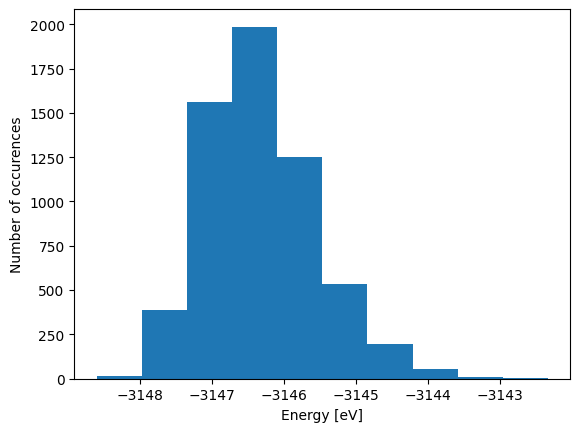

In [66]:
##### DO NOT CHANGE #####
# plot the distribution of energies
plt.figure()
plt.hist(energies)
plt.xlabel("Energy [eV]")
plt.ylabel("Number of occurences")
plt.show()

##### DO NOT CHANGE #####

## 1.2 Train-Test-Split

In [67]:
##### DO NOT CHANGE #####
# Calling the libraries for splitting the dataset, and also using the evaluation metrics for the modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
import keras

##### DO NOT CHANGE #####

In [68]:
##### DO NOT CHANGE #####
# Scale energy (to normalize the dataset) and make test split
scaler = StandardScaler(with_std=True, with_mean=True, copy=True)

energy_scaled = scaler.fit_transform(energies[:, np.newaxis])
grads_scaled = grads / scaler.scale_

train_x, test_x, train_g, test_g, train_e, test_e = train_test_split(
    geos, grads_scaled, energy_scaled, test_size=0.2, shuffle=True, random_state=42
)
print(train_x.shape)
print(train_g.shape)
print(train_e.shape)
# The coordinate value for each molecule contains 6 atoms and 3 xyz. The gradiant value for each moelcue...
# ...contains the gradiant of energy for each of 6 atoms in x, y and z direction. However the energy is a global...
# ...value for each molecule and is not for atoms, and it doesnt have a direction.

##### DO NOT CHANGE #####

(4800, 6, 3)
(4800, 6, 3)
(4800, 1)


Now in principle you could already set up a model with TensorFlow-Keras as shown below which simply takes all coordinates as input. You can test it with the data above, but please remove your code again for submission. 
Please have a look at the tensorflow api documentation: https://www.tensorflow.org/api_docs

Here we created a tensorflow model by sequentially setting up the layers of the model. The input tensor is passed from layer to layer within the model. The first dimension is always the batch dimension.
A fully connected neural network is given by `keras.layers.Dense`. With the input-layer we define the input shape from which the hidden weights can be built (Note: you have to call the model once for the weights to actually being initalized). Since we want to use the neural network to model a smooth potential, we will not use "relu" but "selu". We use a regularizer for the kernel-weights.

In [69]:
##### DO NOT CHANGE #####
model = keras.Sequential()
model.add(keras.Input(shape=(6, 3)))
model.add(keras.layers.Flatten())
model.add(
    keras.layers.Dense(
        300,
        use_bias=True,
        activation="selu",
        kernel_regularizer=keras.regularizers.L1(1e-5),
    )
)
model.add(
    keras.layers.Dense(
        300,
        use_bias=True,
        activation="selu",
        kernel_regularizer=keras.regularizers.L1(1e-5),
    )
)
model.add(keras.layers.Dense(1, use_bias=True, activation="linear"))
model.summary()

##### DO NOT CHANGE #####

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 300)            │         5,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,301 (376.18 KB)

 Trainable params: 96,301 (376.18 KB)

 Non-trainable params: 0 (0.00 B)

What could be the problem in this approach? Choose one of the anserwers:

1. The model does not have trainable weights.
2. The model can not deal with input tensor of rank > 1.
3. The model has input features that are not rotation and translation invariant but the model output is.

In [70]:
answer_model_1 = 3  # please pick an answer as int
# YOUR CODE HERE


In [71]:
##### DO NOT CHANGE #####
# ID: answer_model1 - possible points: 1

# 1 Point
assert answer_model_1 != 0

##### DO NOT CHANGE #####

## 1.3 Features

With deep-learning APIs like TensorFlow, gradients and jacobians can be computed analytically. We make use of this to compute gradients or forces based on the Neural Network potential. This is further helpful since the gradients have vector properties and will depend on the orientation (not translation) of the molecule. However, to this end, we have to compute the feature descriptors within the model. 

We will do this within a layer named `InverseDistances`. The subclassed layer backbone is shown below. The backward pass is completely taken care of by tensorflow, as long as you use tensorflow functions that have a gradient defined: https://www.tensorflow.org/guide/autodiff

In [72]:
class InverseDistances(keras.layers.Layer):
    def __init__(self, pair_indices=None, **kwargs):
        super().__init__(**kwargs)

        self.pair_indices = pair_indices

    def build(self, input_shape):
        if self.pair_indices is None:
            self.pair_indices = np.array(
                [[i, j] for i in range(input_shape[1]) for j in range(i)],
                dtype=np.int64,
            )
        else:
            self.pair_indices = np.array(self.pair_indices, dtype=np.int64)

        self.tf_pair_indices = self.add_weight(
            name="pair_indices",
            shape=self.pair_indices.shape,
            initializer=keras.initializers.Zeros(),
            dtype="int64",
            trainable=False,
        )

        super().build(input_shape)

        self.set_weights([self.pair_indices])

    def call(self, inputs, **kwargs):
        # Translate the numpy version of the forward layer pass to tensorflow functions
        # Find the appropriate tensorflow functions. Everything must be vectorized.
        # YOUR CODE HERE
        

        cordbatch = inputs
        indexbatch = (
            self.pair_indices
        )  # You may have to add a dimension to indices for tf
        v1 = tf.gather(
            cordbatch, indexbatch[:, 0], axis=1
        )  # You have to find a solution with tf.gather here
        v2 = tf.gather(
            cordbatch, indexbatch[:, 1], axis=1
        )  # For tf check out the batch_dims and axis parameter for tf.gather
        vec = v2 - v1

        norm_vec = tf.sqrt(tf.reduce_sum(tf.square(vec), axis=-1))
        invd_out = 1 / norm_vec

        return invd_out

    def _call_numpy_version_not_use(self, inputs):
        # The same as call with numpy
        cordbatch = inputs
        indexbatch = (
            self.pair_indices
        )  # You may have to add a dimension to indices for tf
        v1 = np.take(
            cordbatch, indexbatch[:, 0], axis=1
        )  # You have to find a solution with tf.gather here
        v2 = np.take(
            cordbatch, indexbatch[:, 1], axis=1
        )  # For tf check out the batch_dims and axis parameter for tf.gather
        vec = v2 - v1
        norm_vec = np.sqrt(np.sum(vec * vec, axis=-1))
        invd_out = 1 / norm_vec
        return invd_out

    def compute_output_shape(self, input_shape: tuple[int, int, int]):
        num_atoms = input_shape[1]
        num_pairs = num_atoms * (num_atoms - 1) // 2
        return (input_shape[0], num_pairs)

In [73]:
##### DO NOT CHANGE #####
# Test layer
test_layer = InverseDistances(dtype="float64")
test_layer.build(geos[:10, :, :].shape)
result_test_layer = test_layer(geos[:10, :, :]).numpy()
result_test_numpy = test_layer._call_numpy_version_not_use(geos[:10, :, :])
result_test_numpy.shape

##### DO NOT CHANGE #####

(10, 15)

In [74]:
##### DO NOT CHANGE #####
# ID: InvdLayer - possible points: 3

# 3 Points
assert np.sum(np.abs(result_test_layer - result_test_numpy)) < 1e-6

##### DO NOT CHANGE #####

In principle we can make now a model like shown below. However, it turns out that training with the prediction of the gradients leads to overall better results. Note the non-trainable weights for the indices that come from our custom layer.

In [75]:
##### DO NOT CHANGE #####
model = keras.Sequential()
model.add(keras.Input(shape=(6, 3)))
model.add(InverseDistances(name="InverseDistance"))
model.add(
    keras.layers.Dense(
        300,
        use_bias=True,
        activation="selu",
        kernel_regularizer=keras.regularizers.L1(1e-5),
    )
)
model.add(
    keras.layers.BatchNormalization(
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
)
)
model.add(
    keras.layers.Dense(
        300,
        use_bias=True,
        activation="selu",
        kernel_regularizer=keras.regularizers.L1(1e-5),
    )
)
model.add(keras.layers.Dense(1, use_bias=True, activation="linear"))
model.summary()

##### DO NOT CHANGE #####

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InverseDistance                 │ (None, 15)             │            30 │
│ (InverseDistances)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 300)            │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,631 (377.58 KB)

 Trainable params: 96,001 (375.00 KB)

 Non-trainable params: 630 (2.58 KB)

Why could it be more advantageous to train with energy AND forces as model output?

1. The forces are not connected to the energies and therefore needs to be in the training set.
2. Adding the forces makes training much faster
3. The gradients determine the slope of the potential energy surface and act as an additional form of regularization.

In [76]:
answer_gradient = 3  # select the number of the correct answer
# YOUR CODE HERE


In [77]:
##### DO NOT CHANGE #####
# ID: AnswerGradient - possible points: 1

# 1 Point
assert answer_gradient != 0

##### DO NOT CHANGE #####

## 1.4 Energy + Gradients

We can improve the gradient prediction if we train on energies and gradients simultaneously. To do this the analytical gradient prediction has to be integrated into the model. A subclassing of a keras.model allows for implementing a more general model definition than the simply sequential model constructor.

In [78]:
##### DO NOT CHANGE #####
class EnergyGradientModel(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.feat_layer = InverseDistances()

        self.dense_layers = [
            keras.layers.Dense(
                300,
                use_bias=True,
                activation="selu",
                kernel_regularizer=keras.regularizers.L1(1e-5),
            ),
            keras.layers.Dense(
                300,
                use_bias=True,
                activation="selu",
                kernel_regularizer=keras.regularizers.L1(1e-5),
            ),
        ]

        self.energy_layer = keras.layers.Dense(1, use_bias=True, activation="linear")

    def build(self, input_shape):
        self.feat_layer.build(input_shape)
        input_shape = self.feat_layer.compute_output_shape(input_shape)

        for layer in self.dense_layers:
            layer.build(input_shape)
            input_shape = layer.compute_output_shape(input_shape)

        self.energy_layer.build(input_shape)

        super().build(input_shape)

    def call(self, inputs, training=False, **kwargs):
        x = inputs
        with tf.GradientTape() as tape:
            tape.watch(x)
            hidden = self.feat_layer(x)
            for d in self.dense_layers:
                hidden = d(hidden, training=training)
            temp_e = self.energy_layer(hidden)
        temp_g = tape.batch_jacobian(temp_e, x)
        temp_g = temp_g[:, 0, :, :]
        return [temp_e, temp_g]

##### DO NOT CHANGE #####

In [79]:
##### DO NOT CHANGE #####
model = EnergyGradientModel()
model.build(train_x.shape)

##### DO NOT CHANGE #####

In [80]:
##### DO NOT CHANGE #####
# Compile and Training of the model
def compile_train_model(
    model: keras.Model,
    x,
    y,
    validation_data=None,
    epochs=1000,
    lr=0.5e-3,
    validation_freq=10,
    batch_size=128,
    verbose=2,
    loss="mean_squared_error",
    metrics=["mean_absolute_error"],
    loss_weights=None,
):
    # Compile model with optimizer and learning rate
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,
        loss_weights=loss_weights,
    )

    hist = model.fit(
        x,
        y,
        epochs=epochs,
        batch_size=batch_size,
        validation_freq=validation_freq,
        validation_data=validation_data,
        verbose=2,
    )

    return hist

##### DO NOT CHANGE #####

Please submit your solution with `do_training = False`.

In [81]:
do_training = False
# YOUR CODE HERE


In [82]:
##### DO NOT CHANGE #####
if do_training:
    hist = compile_train_model(
        model,
        train_x,
        [train_e, train_g],
        validation_data=(test_x, [test_e, test_g]),
        loss=["mean_squared_error", "mean_squared_error"],
        metrics=[["mean_absolute_error"], ["mean_absolute_error"]],
        loss_weights=[1, 5],
    )

##### DO NOT CHANGE #####

In [83]:
##### DO NOT CHANGE #####
# Some plotting functions.
def plot_history(hist, validation_freq=10, scale=1):
    plt.figure()
    for key, loss in hist.history.items():
        np_loss = np.array(loss)
        if "val" in key:
            plt.plot(
                np.arange(np_loss.shape[0]) * validation_freq + validation_freq,
                np_loss,
                label=key,
            )
        else:
            plt.plot(np.arange(np_loss.shape[0]), np_loss, label=key)

    plt.xlabel("Epochs")
    plt.ylabel("Loss ")
    plt.title("Loss vs. epochs")
    plt.legend(loc="upper right", fontsize="x-small")
    plt.show()


def plot_prediction(pred, true):
    mae_valid = np.mean(np.abs(pred - true))
    r2_data = r2_score(true, pred)
    print("MAE", mae_valid)
    print("r2_score", r2_data)
    plt.figure()
    plt.scatter(
        pred.flatten(),
        true.flatten(),
        alpha=0.3,
        label="MAE: {0:0.4f} \nr2 {1:0.4f}".format(mae_valid, r2_data),
    )
    plt.plot(
        np.linspace(np.amin(true), np.amax(true), 100),
        np.linspace(np.amin(true), np.amax(true), 100),
        color="red",
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.legend(loc="upper left", fontsize="x-large")
    plt.show()

##### DO NOT CHANGE #####

In [84]:
##### DO NOT CHANGE #####
if do_training:
    pred_test = scaler.inverse_transform(model.predict(test_x)[0])
    true_test = scaler.inverse_transform(test_e)
    pred_test_grad = model.predict(test_x)[1] * scaler.scale_
    true_test_grad = test_g * scaler.scale_

    plot_history(hist, validation_freq=10, scale=scaler.scale_)
    plot_prediction(pred_test, true_test)
    plot_prediction(
        np.reshape(pred_test_grad, (-1, 18)), np.reshape(true_test_grad, (-1, 18))
    )

##### DO NOT CHANGE #####

Please report on your achieved validation r2_score. You can change the hyperparemeters and play with the model definition. Eg. add a few layers or add a BatchNormalization layer after the Feature layer etc.

In [85]:
r2_score_energy = 0.9905
r2_score_gradient = 0.9953
# YOUR CODE HERE


In [86]:
##### DO NOT CHANGE #####
# ID: Testr2score - possible points: 3

# 3 Points
assert r2_score_energy > 0.90
assert r2_score_gradient > 0.90

##### DO NOT CHANGE #####

# MD Simulation

(If we have the forces on each atom, calculating their velocity and movements are possible. After getting the new positions, we need to calculate the forces again and continue this process until the energy reaches to minimum. Normally caluclating the new forces in each step and the correponsing energy of the molecule is the job of expensive computations. With trained and accurate ML models, we could bypass this setp and predict the energy and the forces (gradients) faster and computationally cheaper). 

For time integration the so-called ["Verlet"](https://en.wikipedia.org/wiki/Verlet_integration) integration is used to integrate Newton's equations of motion.

The standard scheme of this algorithm is:

* Calculate ${\displaystyle {\vec {v}}\left(t+{\tfrac {1}{2}}\,\Delta t\right)={\vec {v}}(t)+{\tfrac {1}{2}}\,{\vec {a}}(t)\,\Delta t}$.

* Calculate ${\displaystyle {\vec {x}}(t+\Delta t)={\vec {x}}(t)+{\vec {v}}\left(t+{\tfrac {1}{2}}\,\Delta t\right)\,\Delta t}$.

* Derive ${\displaystyle {\vec {a}}(t+\Delta t)}$ from the interaction potential using ${\displaystyle {\vec {x}}(t+\Delta t)}$.

* Calculate ${\displaystyle {\vec {v}}(t+\Delta t)={\vec {v}}\left(t+{\tfrac {1}{2}}\,\Delta t\right)+{\tfrac {1}{2}}\,{\vec {a}}(t+\Delta t)\Delta t}$.

Here is an implementation in python with different time-integration.

In [87]:
##### DO NOT CHANGE #####
# first we need a wrapper around our trained neural network, to generate the output needed in MD
class PotentialNN:
    unit_Bohr_A = 0.52917721090380
    unit_Hatree_eV = 27.21138624598853

    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler

    def __call__(self, x):
        # x in Bohr to eV
        x_A = x * self.unit_Bohr_A
        # call model
        eng, grad = self.model.predict(x_A)
        # inverse scaling
        eng = self.scaler.inverse_transform(eng)
        grad = grad * self.scaler.scale_
        # unit conversion to Hatree and Hatree/Bohr
        eng_B = eng / self.unit_Hatree_eV
        grad_BH = grad / self.unit_Hatree_eV * self.unit_Bohr_A
        return eng_B, grad_BH

##### DO NOT CHANGE #####

In [88]:
##### DO NOT CHANGE #####
# Then we need a MD ensemble


class BatchEnsemble:
    unit_Bohr_A = 0.52917721090380
    unit_Bohr_m = 5.2917721090380e-11
    unit_me_kg = 9.109383701528e-31
    unit_Hatree_eV = 27.21138624598853
    unit_Hatree_J = 4.359744722207185e-18
    unit_atu_s = 2.418884326585747e-17
    unit_1u_me = 1.6605390666050e-27 / 9.109383701528e-31

    const_kB = 8.617333262e-5 / 27.21138624598853
    sign_force = -1.0

    def __init__(self, coord, mass, potential, velo=None):
        """Initial settings. All properties are in atomic units.

        Args:
            coord (np.array): Initial poisition of shape (batch, N, 3) in [Bohr]
            mass (np.array): Mass of particles (bath, N, 1) in [me]
            potential (callable): Potential model inputs coord and returns energies and gradients
                                  of shape (batch, 1) and (batch, N, 3) in [Hatree] and [Hatree/Bohr]
            velo (np.array): Initial velocities of shape (batch, N, 3)
        """

        # System properties
        self.mass = mass
        self.potential = potential
        self.number_particles = self.mass.shape[1]

        # Trajectory properties
        self.traj_x = []  # position in Bohr
        self.traj_v = []  # velicity in Bohr/atu
        self.traj_a = []  # acceleraton in Bohr/atu^2
        self.traj_t = []  # time in atu
        self.traj_p = []  # momentum in Bohr*me/atu
        self.traj_F = []  # force in Hatree/Bohr
        self.traj_E = []  # potential energy in Hatree
        self.traj_E_kin = []  # kinetic energy in Hatree
        self.traj_T = []  # Temperature in K

        #######################################################################

        # Set initial values i.e. traj[0]
        initial_x = coord
        if velo is None:
            initial_v = np.zeros_like(coord)
        else:
            initial_v = velo
        initial_p = initial_v * self.mass
        initial_eng, initial_grad = self.potential(initial_x)
        initial_force = self.sign_force * initial_grad
        initial_eng_kin = np.sum(
            np.sum(0.5 * self.mass * initial_v * initial_v, axis=-1),
            axis=-1,
            keepdims=True,
        )
        initial_temp = 2 / 3 * initial_eng_kin / self.number_particles / self.const_kB
        initial_a = initial_force / self.mass

        # Add initial values to trajectory
        self.add_point(
            t=0.0,
            x=initial_x,
            v=initial_v,
            a=initial_a,
            F=initial_force,
            E=initial_eng,
            E_kin=initial_eng_kin,
            T=initial_temp,
            p=initial_p,
        )

    def add_point(
        self,
        t: float,
        x: NDArray,
        v: NDArray,
        a: NDArray,
        F: NDArray,
        E: NDArray,
        E_kin: NDArray,
        T: NDArray,
        p: NDArray,
    ):
        """Add point to trajectory.

        Args:
            t (float): Time in atu
            x (np.array): Position in Bohr
            v (np.array): Velocity in Bohr/atu
            a (np.array): Acceleration in Bohr/atu^2
            F (np.array): Force in Hatree/Bohr
            E (np.array): Potential energy in Hatree
            E_kin (np.array): Kinetic energy in Hatree
            T (np.array): Temperature in K
            p (np.array): Momentum in Bohr*me/atu
        """
        self.traj_t.append(t)
        self.traj_x.append(x)
        self.traj_v.append(v)
        self.traj_a.append(a)
        self.traj_F.append(F)
        self.traj_E.append(E)
        self.traj_E_kin.append(E_kin)
        self.traj_T.append(T)
        self.traj_p.append(p)

    def initialize_velocity(self, T):
        """Overwrite initial velcovity by Boltzmann distribution.

        Args:
            T (float): Temperature in K
        """
        initial_velo = np.random.standard_normal(self.traj_x[0].shape)
        initial_velo = initial_velo * np.sqrt(self.const_kB * T / self.mass)
        initial_eng_kin = np.sum(
            np.sum(0.5 * self.mass * initial_velo * initial_velo, axis=-1),
            axis=-1,
            keepdims=True,
        )
        initial_p = initial_velo * self.mass
        initial_T = 2 / 3 * initial_eng_kin / self.number_particles / self.const_kB

        self.traj_v[0] = initial_velo
        self.traj_E_kin[0] = initial_eng_kin
        self.traj_T[0] = initial_T
        self.traj_p[0] = initial_p

##### DO NOT CHANGE #####

In [89]:
##### DO NOT CHANGE #####
# This class is like a MD propagater which include time steps for the simulation to happen repeatedly
class TimeIntegration:
    unit_atu_s = 2.418884326585747e-17
    const_kB = 8.617333262e-5 / 27.21138624598853

    def __init__(self, ensemble: BatchEnsemble):
        self.ensemble = ensemble

    def propagate_timestep(self):
        """Propagate ensemble for one time step."""
        # Get current values
        x = self.ensemble.traj_x[-1]
        v = self.ensemble.traj_v[-1]
        a = self.ensemble.traj_a[-1]
        F = self.ensemble.traj_F[-1]
        E = self.ensemble.traj_E[-1]
        E_kin = self.ensemble.traj_E_kin[-1]
        T = self.ensemble.traj_T[-1]
        p = self.ensemble.traj_p[-1]

        # Calculate new values
        new_x = x + v * self.unit_atu_s
        new_v = v + a * self.unit_atu_s
        new_p = p + F * self.unit_atu_s
        new_a = F / self.ensemble.mass

        # Get potential energy and force
        new_E, new_F = self.ensemble.potential(new_x)

        # Calculate kinetic energy and temperature
        new_E_kin = np.sum(
            np.sum(0.5 * self.ensemble.mass * new_v * new_v, axis=-1),
            axis=-1,
            keepdims=True,
        )
        new_T = 2 / 3 * new_E_kin / self.ensemble.number_particles / self.const_kB

        # Add new point to trajectory
        new_t = self.ensemble.traj_t[-1] + self.unit_atu_s
        self.ensemble.add_point(
            t=new_t,
            x=new_x,
            v=new_v,
            a=new_a,
            F=new_F,
            E=new_E,
            E_kin=new_E_kin,
            T=new_T,
            p=new_p,
        )
        

    def propagate(self, time_length, step_size):
        """Propagate ensemble.

        Args:
            time_length: Time of the simulation in [fs]
            step_size: Time step in [fs]
        """
        # Repeat time step
        num_steps = int(time_length / step_size)

        # Map to atu
        time_length = time_length * 1e-15 / self.unit_atu_s
        step_size = step_size * 1e-15 / self.unit_atu_s
        print("Run MD for:", time_length, "a.t.u with steps:", step_size, "a.t.u")

        # Run MD
        for i in range(num_steps):
            self.propagate_timestep(step_size)
            if i % 500 == 0:
                print("Steps done:", i)

##### DO NOT CHANGE #####

In [90]:
##### DO NOT CHANGE #####
# One paramter that need to be consdier is that how we need to deal with the termperature? The next two classes consider
# two options, based on which the visulaisation shows you the differnce.
class VerletIntegration(TimeIntegration):
    def __init__(self, ensemble: BatchEnsemble):
        super().__init__(ensemble)

    def propagate_timestep(self, delta_t):
        # time in atu

        t = self.ensemble.traj_t[-1]
        x_t = self.ensemble.traj_x[-1]
        a_t = self.ensemble.traj_a[-1]
        v_t = self.ensemble.traj_v[-1]
        m = self.ensemble.mass
        N = self.ensemble.number_particles
        kB = self.const_kB
        sig_F = self.ensemble.sign_force

        v_t_dt_2 = v_t + 0.5 * a_t * delta_t
        x_t_dt = x_t + v_t_dt_2 * delta_t

        e_t_dt, g_t_dt = self.ensemble.potential(x_t_dt)
        a_t_dt = sig_F * g_t_dt / m

        v_t_dt = v_t_dt_2 + 0.5 * a_t_dt * delta_t
        e_kin_t_dt = np.sum(
            np.sum(0.5 * m * v_t_dt * v_t_dt, axis=-1), axis=-1, keepdims=True
        )
        p_t_dt = v_t_dt * m
        T_dt = 2 / 3 * e_kin_t_dt / N / kB

        self.ensemble.add_point(
            t=t + delta_t,
            x=x_t_dt,
            v=v_t_dt,
            a=a_t_dt,
            F=sig_F * g_t_dt,
            E=e_t_dt,
            E_kin=e_kin_t_dt,
            T=T_dt,
            p=p_t_dt,
        )

##### DO NOT CHANGE #####

A thermostat allows us to control the temperature of the system during the simulation.

In [91]:
##### DO NOT CHANGE #####
class BerendsenThermostat(TimeIntegration):
    def __init__(self, ensemble: BatchEnsemble, f_cool=0, T0=300):
        """Make Time Integration with Berendsen Thermostat for Verlet.

        Args:
            ensemble: BatchEnsemble class
            f_cool: Colling coupling as frequency in [fs]
            T0: Temperature of bath [K]
        """
        self.ensemble = ensemble
        self.f_cool = f_cool / 1e-15 * self.unit_atu_s
        self.T0 = T0

    def propagate_timestep(self, delta_t):
        # time in atu

        t = self.ensemble.traj_t[-1]
        x_t = self.ensemble.traj_x[-1]
        a_t = self.ensemble.traj_a[-1]
        v_t = self.ensemble.traj_v[-1]
        m = self.ensemble.mass
        N = self.ensemble.number_particles
        kB = self.const_kB
        sig_F = self.ensemble.sign_force
        f_cool = self.f_cool

        v_t_dt_2 = v_t + 0.5 * a_t * delta_t

        e_kin_t_dt_2 = np.sum(
            np.sum(0.5 * m * v_t_dt_2 * v_t_dt_2, axis=-1), axis=-1, keepdims=True
        )
        T_dt_2 = 2 / 3 * e_kin_t_dt_2 / N / kB
        lamd = np.sqrt(1 + f_cool * delta_t * (self.T0 / T_dt_2 - 1))

        x_t_dt = x_t + v_t_dt_2 * delta_t

        e_t_dt, g_t_dt = self.ensemble.potential(x_t_dt)
        a_t_dt = sig_F * g_t_dt / m

        v_t_dt = v_t_dt_2 + 0.5 * a_t_dt * delta_t
        v_t_dt = np.expand_dims(lamd, axis=-1) * v_t_dt
        e_kin_t_dt = np.sum(
            np.sum(0.5 * m * v_t_dt * v_t_dt, axis=-1), axis=-1, keepdims=True
        )
        p_t_dt = v_t_dt * m
        T_dt = 2 / 3 * e_kin_t_dt / N / kB

        # Add time-step
        self.ensemble.add_point(
            t=t + delta_t,
            x=x_t_dt,
            v=v_t_dt,
            a=a_t_dt,
            F=sig_F * g_t_dt,
            E=e_t_dt,
            E_kin=e_kin_t_dt,
            T=T_dt,
            p=p_t_dt,
        )

##### DO NOT CHANGE #####

Now we can run a very simple MD simulation for a batch of molecules. We take the energy minimum and initialize a batch of molecules with temperature T. We also have to provide mass and the neural network potential in matching units. Please submit you notebook with `do_poropgate = False` and `show_trajectory = False`.

In [92]:
do_poropgate = False
show_trajectory = False
# YOUR CODE HERE


In [93]:
##### DO NOT CHANGE #####
# Make a batch molecules.
lowest = np.argsort(energies)[0]
print("Energy Minimum", energies[lowest])
x_md = geos[lowest]
x_md = np.repeat(np.expand_dims(x_md, axis=0), 10, axis=0)
x_md = x_md / PotentialNN.unit_Bohr_A
mass = (
    np.array([[[12.0], [15.99491], [1.007825], [1.007825], [1.007825], [1.007825]]])
    * BatchEnsemble.unit_1u_me
)

# Setup Ensemble and MD simulation
potential = PotentialNN(model, scaler)
ensemble_md = BatchEnsemble(x_md, mass, potential)
ensemble_md.initialize_velocity(1000.0)
trajectory_md = VerletIntegration(ensemble_md)

##### DO NOT CHANGE #####

Energy Minimum -3148.5957961
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


In [94]:
##### DO NOT CHANGE #####
if do_poropgate:
    trajectory_md.propagate(1000, 1)
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    for i in range(10):
        plt.plot(
            np.array(ensemble_md.traj_t),
            np.array(ensemble_md.traj_E)[:, i, 0],
            label=str(i),
        )
    plt.legend(loc="right")
    plt.xlabel("Time [a.t.u]")
    plt.ylabel("Potential Energy [Hatree]")
    plt.subplot(122)
    for i in range(10):
        plt.plot(
            np.array(ensemble_md.traj_t),
            np.array(ensemble_md.traj_T)[:, i, 0],
            label=str(i),
        )
    plt.legend(loc="right")
    plt.xlabel("Time [a.t.u]")
    plt.ylabel("Temperature [K]")
    plt.ylim([0, 2000])
    plt.show()

##### DO NOT CHANGE #####

Make sure you see the graph at the end of the modelling in the previous cell. If you are using google colab to answer and run the notebook you can look at a molecule from the batch with the py3Dmol viewer (This viewer is also available in jupyter notebook and we already installed and imported it in the beginning)).

In [95]:
##### DO NOT CHANGE #####
# exports a series of molecules to a xyz file
def exportXYZs(coords_all, elements_all, filename):
    outfile = open(filename, "w")
    for molidx in range(len(coords_all)):
        outfile.write("%i\n\n" % (len(elements_all[molidx])))
        for atomidx, atom in enumerate(coords_all[molidx]):
            outfile.write(
                "%s %f %f %f\n"
                % (
                    elements_all[molidx][atomidx].capitalize(),
                    atom[0],
                    atom[1],
                    atom[2],
                )
            )
    outfile.close()


elements_traj = [elements for i in ensemble_md.traj_x]
coords_traj = [coords[0] * PotentialNN.unit_Bohr_A for coords in ensemble_md.traj_x]

exportXYZs(coords_traj, elements_traj, "MD_traj_1.xyz")

##### DO NOT CHANGE #####

In [96]:
##### DO NOT CHANGE #####
if show_trajectory:
    viewer = py3Dmol.view(width=600, height=300)
    viewer.addModelsAsFrames(open("MD_traj_1.xyz", "r").read(), "xyz")
    viewer.setStyle({"stick": {}})
    viewer.zoomTo()
    viewer.animate({"loop": "forward", "reps": 1, "interval": 100})
    viewer.show()

##### DO NOT CHANGE #####

You notice a large spread in the initial temperatures. Have a look at the method `initialize_velocity` in the definition of the `BatchEnsemble` class. What could be a better way to initialized the velocities to achieve a specific kinetic energy or temperature. 

1. Set all $\forall v \in \mathbb{R}^3: v_{x,y,z} = v_0 $ constant.
2. Choose a $|v|$ from Maxwell-Boltzmann distribution and a random direction for each atom, remove the COM velocity and rescale according to desired temperature.
3. Set all $v = 0$ and adjust potential scale.

In [97]:
answer_md_v = 2  # choose the correct answer
# YOUR CODE HERE


In [98]:
##### DO NOT CHANGE #####
# ID: answermd - possible points: 1

# 1 Points
assert answer_md_v != 0

##### DO NOT CHANGE #####

Now we run the MD Simulation with a thermostat. That means we can cool the system during the simulation.

In [99]:
##### DO NOT CHANGE #####
potential = PotentialNN(model, scaler)
ensemble_md = BatchEnsemble(x_md, mass, potential)
ensemble_md.initialize_velocity(1000.0)
trajectory_md = BerendsenThermostat(ensemble_md, f_cool=0.01, T0=5)

##### DO NOT CHANGE #####

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [100]:
##### DO NOT CHANGE #####
if do_poropgate:
    trajectory_md.propagate(2000, 1)
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    for i in range(10):
        plt.plot(
            np.array(ensemble_md.traj_t),
            np.array(ensemble_md.traj_E)[:, i, 0],
            label=str(i),
        )
    plt.legend(loc="right")
    plt.xlabel("Time [a.t.u]")
    plt.ylabel("Potential Energy [Hatree]")
    plt.subplot(122)
    for i in range(10):
        plt.plot(
            np.array(ensemble_md.traj_t),
            np.array(ensemble_md.traj_T)[:, i, 0],
            label=str(i),
        )
    plt.legend(loc="right")
    plt.xlabel("Time [a.t.u]")
    plt.ylabel("Temperature [K]")
    plt.ylim([0, 2000])
    plt.show()

##### DO NOT CHANGE #####

In [101]:
##### DO NOT CHANGE #####
elements_traj = [elements for i in ensemble_md.traj_x]
coords_traj = [coords[0] * PotentialNN.unit_Bohr_A for coords in ensemble_md.traj_x]

exportXYZs(coords_traj, elements_traj, "MD_traj_2.xyz")

##### DO NOT CHANGE #####

In [102]:
##### DO NOT CHANGE #####
# Like before, make sure you have taken a look at the graph after the modelling.
if show_trajectory:
    viewer = py3Dmol.view(width=600, height=300)
    viewer.addModelsAsFrames(open("MD_traj_2.xyz", "r").read(), "xyz")
    viewer.setStyle({"stick": {}})
    viewer.zoomTo()
    viewer.animate({"loop": "forward", "reps": 1, "interval": 25})
    viewer.show()

##### DO NOT CHANGE #####

Compare the time evolution of the simulation with Verlet integration to the one with Berendsen thermostat (make sure to look at the graphs at the end of the simulation run), which one shows the decrease in the temperature and energy of the system? Answer with a string "A" for the Verlet and "B" for the Berendsen. Hint: you could also check the visualization and observe the molecule's vibration over time.

In [103]:
answer_observation = "B"
# YOUR CODE HERE


In [104]:
##### DO NOT CHANGE #####
# ID: Answer_Thermo - possible points: 1

# 1 Point
assert isinstance(answer_observation, str)

##### DO NOT CHANGE #####

In [105]:
##### DO NOT CHANGE #####
# ID: AllOff - possible points: 3

# 3 Points
assert do_training == False
assert do_poropgate == False
assert show_trajectory == False

##### DO NOT CHANGE #####